# Transfer learning, fine-tuning and hyperparameter optimization

This tutorial will walk through the process of transfer learning from a pre-trained network and a minimal approach to hyperparamater optimization. We’ll discuss what transfer learning and hyperparamater optimization are, when to consider them and demonstrate how to do so practically. This is an adaptation of this [example](https://www.tensorflow.org/tutorials/images/transfer_learning#data_download).


A pre-trained model is the result of a network that has been trained already on a large dataset, usually characterized by a high degree of generalization. These models, which require a long training time using significant computing resources, have most often learned to understand very basic representations of features across domains, such as edges and shapes. Because of their generalizability, they can be helpful in expediting the training process for a custom task because they’ve already grasped the basic features, allowing for any new training to focus on the more particular, higher-order features. This is the intuition behind a process known as transfer learning. In practice, transfer learning can help to reduce the amount of time it takes to train a performant custom model. Sometimes pre-trained models are referred to as "backbone" networks.

There are two main strategies to transfer learning, which we will discuss and practice in this tutorial:

1. Feature Extraction: In this technique, we use a portion of the layers from the the pre-trained network (with all of its learnings) to extract features from the custom data, and then append a new classifier (and perhaps several other layers) on top to learn more higher-order further and then classify for the unique task. This process doesn’t retrain any parts of the pre-trained network. It just uses some layers from it that have been “frozen” to derive some basic/generic features from the custom data. Any new layers are targeting the unique classes and characteristics of the custom data.

1. Fine-Tuning: In this technique, we actually “unfreeze” some of the pre-trained network (usually the last few layers) to adjust the learned parameters using custom data. This process allows for the higher-order features of the new, custom data to be directly blended and jointly learned with the information already gathered by the pre-trained network. In effect, this may help make the whole network more relevant to the custom data and task. This technique is best used for situations in which the new training dataset is relatively large and somewhat similar to the original dataset seen by the pre-trained model.

So, now that we have these two tranfer learning strategies and hyperparameter optimization in mind, let’s get started with a practical example. We will revisit the use case in which we want to classify satellite images from the [Eurosat RGB land cover image classification dataset available on TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/eurosat). The goal will be to see how transfer learning and hyperparameter optimization may help us arrive at a performant model quickly.


In [1]:
# install required libraries
!pip install -q rasterio==1.3.8
!pip install -q geopandas==0.13.2

In [2]:
# import required libraries
import os, glob, functools, fnmatch, io, shutil, tarfile, json
from zipfile import ZipFile
from itertools import product
from pathlib import Path
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from google.colab import drive
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [3]:
# set your root directory and working folders
if 'google.colab' in str(get_ipython()):
    # mount google drive
    drive.mount('/content/gdrive')
    root_dir = '/content/gdrive/My Drive/tf-eo-devseed-2/'
    workshop_dir = '/content/gdrive/My Drive/tf-eo-devseed-workshop-2'
    dirs = [root_dir, workshop_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    print('Running on Colab')
else:
    root_dir = os.path.abspath("./data/tf-eo-devseed-2")
    workshop_dir = os.path.abspath('./tf-eo-devseed-workshop-2')
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(root_dir)}')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Running on Colab


In [4]:
%cd $root_dir

/content/gdrive/My Drive/tf-eo-devseed-2


## Data loading and pre-processing

We will again use the Eurosat dataset, which contains labeled Sentinel-2 image patches classified into 10 land cover types. More details here: https://www.tensorflow.org/datasets/catalog/eurosat

The classes in this dataset are: `['Industrial', 'Pasture', 'River', 'Forest', 'AnnualCrop', 'PermanentCrop', 'Highway', 'HerbaceousVegetation', 'Residential', 'SeaLake']`

The dataset will be partitioned into training, validation and testing splits with a 70:20:10 ratio, respectively.

In [5]:
# Construct tf.data.Dataset(s)
all_dataset, ds_info = tfds.load(name="eurosat/rgb", split=tfds.Split.TRAIN, with_info=True)
all_dataset = all_dataset.shuffle(1024)
validation_dataset = all_dataset.take(int(len(all_dataset)*0.3))
train_dataset = all_dataset.skip(int(len(all_dataset)*0.3))
test_dataset = validation_dataset.take(int(len(validation_dataset)*0.3))
validation_dataset = validation_dataset.skip(int(len(validation_dataset)*0.3))

print("Number of samples in each split (train, val, test): ", len(train_dataset), len(validation_dataset), len(test_dataset))

Number of samples in each split (train, val, test):  18900 5670 2430


In [7]:
# Dataset specific parameters to be used in the model structure
INPUT_SHAPE = (64, 64, 3)
NUM_CLASSES = 10
BATCH_SIZE = 4

In [8]:
# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

print("Number of batches in each split (train, val, test): ", len(train_dataset), len(validation_dataset), len(test_dataset))

Number of batches in each split (train, val, test):  4725 1418 608


In [10]:
# Keras expects non-dictionary style format for its input
def convert_dataset(item):
    """Prepares a dict-style dataset in the format Keras expects, (features, labels)."""
    image = item['image']
    label = item['label']
    return image, label

In [11]:
train_dataset = train_dataset.map(convert_dataset)
validation_dataset = validation_dataset.map(convert_dataset)
test_dataset = test_dataset.map(convert_dataset)

In [12]:
# Inspect the structure of the dataset
print(train_dataset.element_spec)

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


Let’s visualize examples of the classes in the dataset

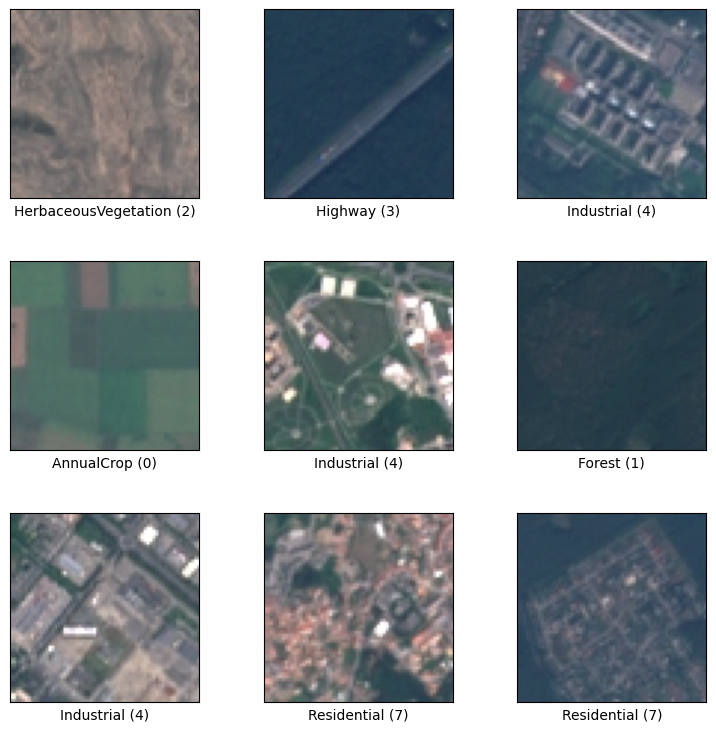

In [13]:
fig = tfds.show_examples(all_dataset, ds_info)

### Prepare the dataset for performance

We will use buffered prefetching to efficiently load samples from disk with I/O blockages. Read more on this technique in this [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Augment the data

We will apply various transformations (that reflect realistic representations) to improve the robustness of our dataset. For example, these will include rotation and flipping. In effect, these will help the model see more variety and avoid overfitting. Another good guide for data augmentation can be found [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: The augmentation layers defined above are only active during training, not during evaluation or prediction.

Let's try these layers on a sample training image and plot the results.

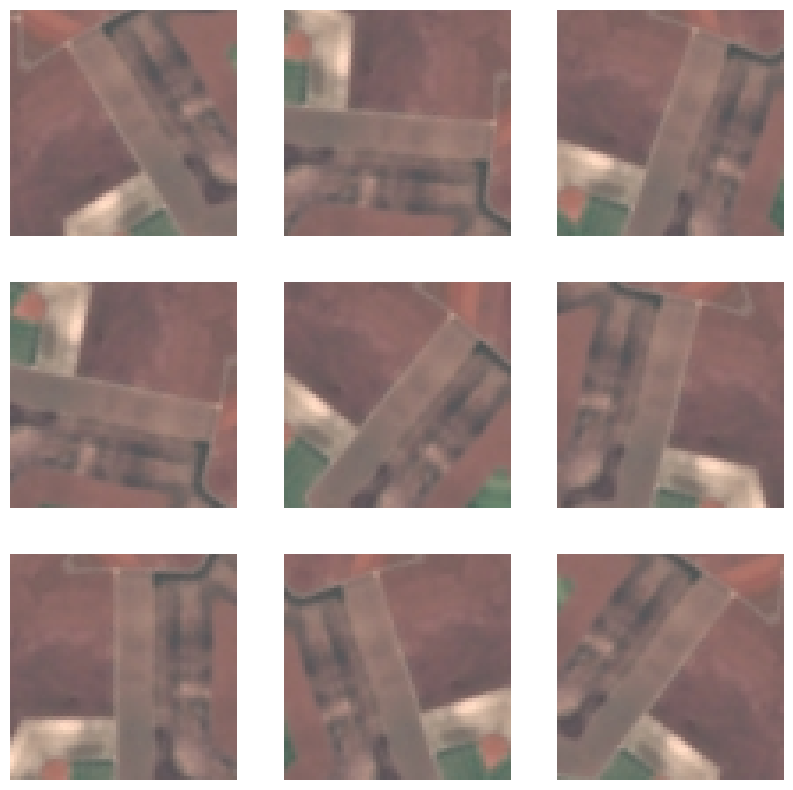

In [24]:
for image, _ in train_dataset.take(1): #batch in train_dataset.take(1):
  #image, label = batch["image"].numpy(), batch["label"].numpy()
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

We want our custom data, in this case the Eurosat images, to fit the scale expected by the pre-trained model. We will load the pretrained `tf.keras.applications.MobileNetV2` model soon, which expects pixel values between `[-1, 1]` so let's rescale the new data to fit that criteria and add this as a preprocessing step in our final model set up.

In [25]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, pixel values can be arbitrarily rescaled from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [26]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: When using `tf.keras.applications` such as the above for MobileNetV2, always check the associated docs to know whether pixels should be scaled within `[-1, 1]` or `[0, 1]`.

## Load the pre-trained network (backbone)
Now we will load the model that will serve as the base from which we transfer learn using our Eurosat dataset. [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2) is a model that was developed at Google. It learned from the ImageNet dataset, which is a large and generalized dataset of natural images which has been used extensively for development of pre-trained models in computer vision.

We will use the final-most pre-classification layer from the pre-trained network, known as the "bottleneck layer", for feature extraction.

A key step when loading the pre-trained network is to specify the `include_top=False` argument, which prevents inclusion of the classification layer.


In [27]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = INPUT_SHAPE
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `64x64x3` image into a `2x2x1280` block of features. Let's see what it does to an example batch of images:

In [29]:
#batch = next(iter(train_dataset))
image_batch, label_batch = next(iter(train_dataset)) #batch["image"].numpy(), batch["label"].numpy()
#print(image_batch)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(4, 2, 2, 1280)


## Feature extraction
The next step is to freeze the pre-trained convolutional network we loaded, and implement it as a feature extractor, which will serve as input to a newly added top-level classifier that we will train using our custom data.

### Freeze the pre-trained network

Freezing the convolutional base network before compiling and training the model is crucial. By setting by setting `layer.trainable = False` for a layer, we ensure its weights don't get updated/re-trained during training. There are many layers in MobileNetV2, so we will just freeze the whole network by setting the entire network's `trainable` flag to False.

In [30]:
base_model.trainable = False

### Critical note for use of BatchNormalization layers

It's common to include `tf.keras.layers.BatchNormalization` layers in a model, but in the context of fine-tuning which we will explore later on, it's important that these layers are treated with precaution.

Under the mode of `layer.trainable = False`, a `BatchNormalization` layer won't apply any updates to its mean and variance statistics. This is called inference mode. Keeping BatchNormalization layers in inference mode during fine-tuning is important, otherwise, the non-trainable weights will be updated and this will corrupt what the pre-trained model has already learned.

More on this can be read in this [transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [31]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

### Add a new classification layer (head)

We will add a layer that averages over the feature maps and produce a flat vector for each sample in the batch.

In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(4, 1280)


From this, we add the classification layer, `tf.keras.layers.Dense`, to obtain a single prediction per image from the averaged feature maps. This will produce `logits`, raw prediction values for each class.

In [33]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(4, 10)


Now we will put everything together and build a model that includes the data augmentation, rescaling, feature extractor layers and classification head using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). Of note, we are setting `training=False` because this model contains a `BatchNormalization` layer.

In [34]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model. There are 10 classes in the Eurosat dataset, so we will use an appropriate loss function for multi-class classification, `tf.keras.losses.SparseCategoricalCrossentropy`, with `from_logits=True` as this model generates linear output.

In [35]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                             

The over 2 million parameters in the frozen MobileNetV2 backbone, and much fewer which are _trainable_ parameters in our added Dense layer. These parameters are all divided between two key `tf.Variable` objects: weights and biases.

In [37]:
len(model.trainable_variables)

2

### Train the model

We will train for some epochs, and then check the accuracy on the validation set.


In [38]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

1418/1418 [==============================] - 22s 14ms/step - loss: 2.8733 - accuracy: 0.0952


In [39]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.87
initial accuracy: 0.10


In [40]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
4725/4725 [==============================] - 74s 14ms/step - loss: 1.1513 - accuracy: 0.6145 - val_loss: 0.6628 - val_accuracy: 0.7847
Epoch 2/10
4725/4725 [==============================] - 61s 13ms/step - loss: 0.6991 - accuracy: 0.7739 - val_loss: 0.5474 - val_accuracy: 0.8205
Epoch 3/10
4725/4725 [==============================] - 69s 15ms/step - loss: 0.6034 - accuracy: 0.8005 - val_loss: 0.4916 - val_accuracy: 0.8406
Epoch 4/10
4725/4725 [==============================] - 79s 17ms/step - loss: 0.5631 - accuracy: 0.8160 - val_loss: 0.4659 - val_accuracy: 0.8481
Epoch 5/10
4725/4725 [==============================] - 80s 17ms/step - loss: 0.5366 - accuracy: 0.8241 - val_loss: 0.4368 - val_accuracy: 0.8547
Epoch 6/10
4725/4725 [==============================] - 69s 15ms/step - loss: 0.5233 - accuracy: 0.8285 - val_loss: 0.4215 - val_accuracy: 0.8616
Epoch 7/10
4725/4725 [==============================] - 70s 15ms/step - loss: 0.5209 - accuracy: 0.8296 - val_loss: 0.4303 -

### Learning curves

The learning curves for the training and validation accuracy/loss help us visualize what happens when we use the MobileNetV2 pre-trained model as a fixed feature extractor.

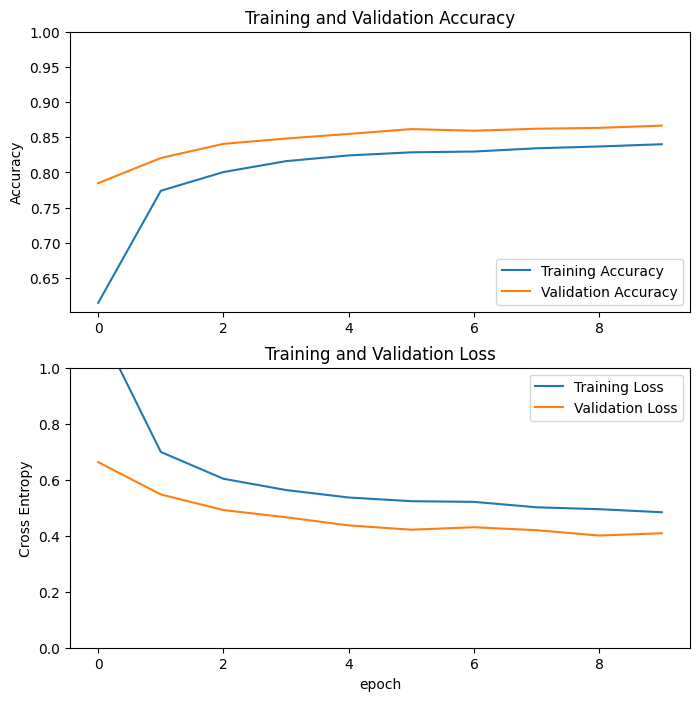

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note that the validation metrics are better than the training metrics. This is mainly the case because certain layers such as `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` impact accuracy during training. However, they are inactive when calculating validation loss. A second yet much more minor reason for why the training metrics are lower is because
validation metrics are evaluated at the end of each epoch while training metrics are calculated as an average in each epoch. Therefore, validation metrics represent the concrete end of an epoch not the interim progress.

Now let's measure the performance of the model on new data from the test set.

In [42]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

608/608 [==============================] - 6s 10ms/step - loss: 0.4570 - accuracy: 0.8486
Test accuracy : 0.8485596776008606


## Fine tuning

When we were using the pre-trained network for feature extraction alone, we were only training a minimal set of added layers on top of the MobileNetV2 backbone. None of the backbone was trained.

It’s possible we can improve the accuracy of our model further by fine-tuning the weights from the final-most pre-classification layers of the backbone by training them with our added classification layers.

This fused training should refine the pre-trained feature maps from a generic to more specific representation of the custom data.

Note: It’s best to fine-tune after having trained the top-level classifier with the backbone set to non-trainable. Reason being, if we were to try to jointly train a randomly initialized classifier on top of a pre-trained model, the computed gradients will be too large, causing major gradient updates and information degradation to the pre-trained model. As well, a best practice is to only fine-tune a minimal set of top-most layers from the backbone instead of the entire network since the bottom-most layers are really just learning simple, generic features. This harkens back to the goal of fine-tuning, which is to refine the higher-order feature maps to the custom data.


### Un-freeze some top layers of the model


We will unfreeze our backbone, the `base_model`, and instead, just set the bottom (generic) layers to be un-trainable.

In [269]:
base_model.trainable = True

In [270]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model
We must then recompile the model for these changes to take effect. It's key to use a low learning rate because otherwise, we might overfit with such a large model.

In [271]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [272]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 sequential_4 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 64, 64, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 64, 64, 3)        0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                           

In [273]:
len(model.trainable_variables)

56

### Continue training the model

Lastly, we will fine-tune by resuming training.

In [274]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
4725/4725 [==============================] - 106s 20ms/step - loss: 0.4967 - accuracy: 0.8401 - val_loss: 0.3617 - val_accuracy: 0.8862
Epoch 11/20
4725/4725 [==============================] - 92s 19ms/step - loss: 0.3854 - accuracy: 0.8757 - val_loss: 0.2945 - val_accuracy: 0.9065
Epoch 12/20
4725/4725 [==============================] - 91s 19ms/step - loss: 0.3262 - accuracy: 0.8981 - val_loss: 0.2591 - val_accuracy: 0.9196
Epoch 13/20
4725/4725 [==============================] - 90s 19ms/step - loss: 0.3073 - accuracy: 0.9047 - val_loss: 0.2564 - val_accuracy: 0.9235
Epoch 14/20
4725/4725 [==============================] - 91s 19ms/step - loss: 0.2839 - accuracy: 0.9120 - val_loss: 0.2073 - val_accuracy: 0.9383
Epoch 15/20
4725/4725 [==============================] - 95s 20ms/step - loss: 0.2796 - accuracy: 0.9156 - val_loss: 0.2107 - val_accuracy: 0.9354
Epoch 16/20
4725/4725 [==============================] - 91s 19ms/step - loss: 0.2755 - accuracy: 0.9184 - val_loss: 

Again, the learning curves for the training and validation accuracy/loss help us visualize what happens when we fine-tune using the MobileNetV2 pre-trained model. Overfitting may be happening if we see a much higher validation loss compared to its training counterpart. This is not abnormal as the new, custom data is much smaller than that which was initially used to train the MobileNetV2 backbone.


In [275]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

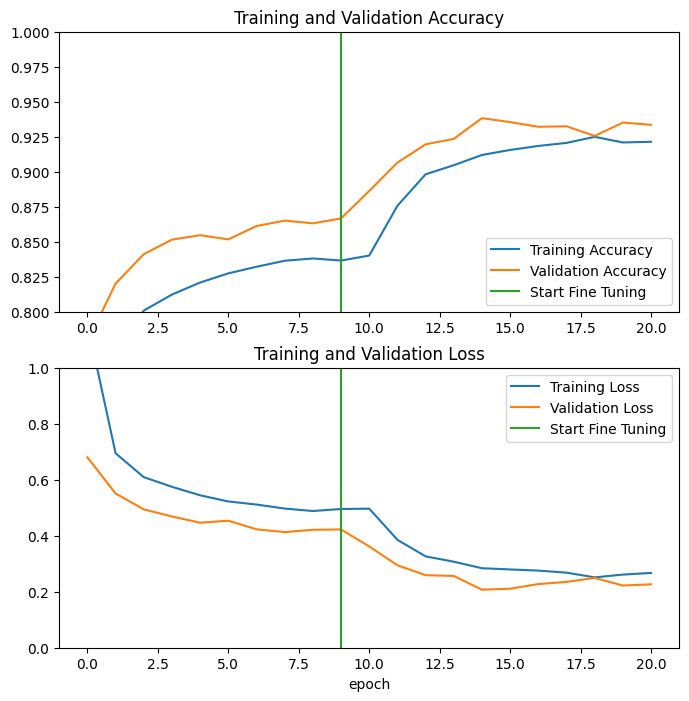

In [276]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Now let's measure the performance of the fine-tuned model on new data from the test set.

In [277]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

608/608 [==============================] - 6s 9ms/step - loss: 0.2334 - accuracy: 0.9296
Test accuracy : 0.9296296238899231


With this model, we can predict the probabilities of an image belonging to one of the 10 classes.

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

print(len(predictions.numpy()), len(label_batch))

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.